# MLDL2 Homework 3

In [1]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
from torchvision import datasets
import torch.nn.functional as F
from tqdm.auto import tqdm

ModuleNotFoundError: No module named 'torch'

# 1. Load the CIFAR-10, CIFAR-100 Datasets

In [12]:
BATCH_SIZE = 64

# Use only train datasets of CIFAR-10 & 100
cifar10_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.491, 0.482, 0.447), (0.247, 0.244, 0.262))
    ])

cifar100_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.507, 0.487, 0.441), (0.267, 0.256, 0.276))
    ])

cifar10_train_dataset = datasets.CIFAR10(root="./data/", train=True, download=True, transform=cifar10_transform)
cifar100_train_dataset = datasets.CIFAR100(root="./data/", train=True, download=True, transform=cifar100_transform)

cifar10_train_loader = torch.utils.data.DataLoader(dataset=cifar10_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
cifar100_train_loader = torch.utils.data.DataLoader(dataset=cifar100_train_dataset, batch_size=BATCH_SIZE, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


# 2. Load the Caltech UCSD Birds-200 Dataset

In [13]:
class CUB_Dataset(Dataset):
    def __init__(self,img_file, label_file, transform=None):
        self.img =np.load(img_file)
        self.labels = np.load(label_file)
        self.transform = transform

    def __len__(self):
        return len(self.img)

    def __getitem__(self, idx):
        image = self.img[idx]
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]

        return image,label

cub_bird_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

cub_train_dataset = CUB_Dataset(img_file="./CUB_train_images.npy",
                                        label_file="./CUB_train_labels.npy",transform=cub_bird_transform)
cub_train_loader = torch.utils.data.DataLoader(cub_train_dataset, batch_size=BATCH_SIZE, shuffle=True)

cub_val_dataset = CUB_Dataset(img_file="./CUB_val_images.npy",
                                        label_file="./CUB_val_labels.npy",transform=cub_bird_transform)
cub_val_loader = torch.utils.data.DataLoader(cub_val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [14]:
# Number of samples in the dataset

print("cifar10 train dataset size : ", len(cifar10_train_dataset))
print("cifar100 train dataset size : ", len(cifar100_train_dataset))
print("caltech bird train dataset size : ", len(cub_train_dataset))
print("caltech bird validation dataset size : ", len(cub_val_dataset))

cifar10 train dataset size :  50000
cifar100 train dataset size :  50000
caltech bird train dataset size :  5994
caltech bird validation dataset size :  2897


## CIFAR-10 Visualiztion

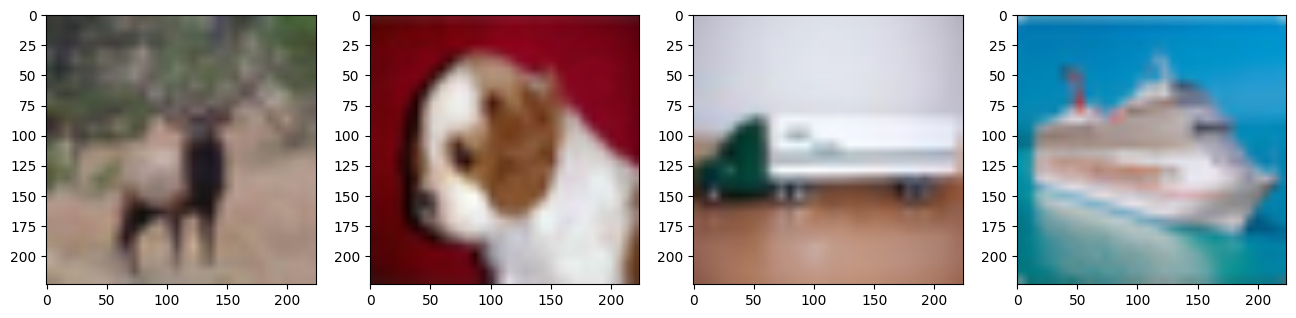

tensor([4, 5, 9, 8])


In [15]:
# Plot the training images and labels

cifar10_denormalize = transforms.Normalize(mean=[-0.491/0.247, -0.482/0.244, -0.447/0.262], std=[1/0.247, 1/0.244, 1/0.262])
to_pil_image = transforms.functional.to_pil_image

images, labels = next(iter(cifar10_train_loader))

fig, ax = plt.subplots(1, 4, figsize=(16, 4))
ax[0].imshow(to_pil_image(cifar10_denormalize(images[0])))
ax[1].imshow(to_pil_image(cifar10_denormalize(images[1])))
ax[2].imshow(to_pil_image(cifar10_denormalize(images[2])))
ax[3].imshow(to_pil_image(cifar10_denormalize(images[3])))
plt.show()

print(labels[:4])

## CIFAR-100 Visualiztion

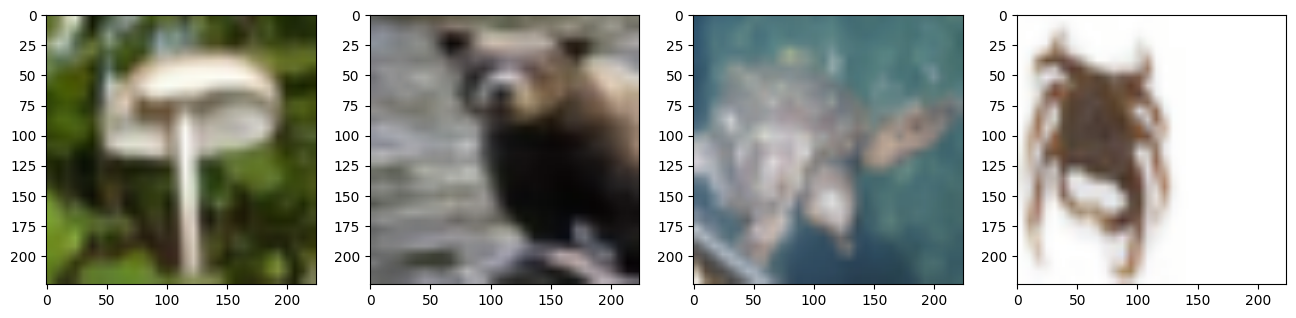

tensor([51,  3, 93, 26])


In [16]:
# Plot the training images and labels

cifar100_denormalize = transforms.Normalize(mean=[-0.507/0.267, -0.487/0.256, -0.441/0.276], std=[1/0.267, 1/0.256, 1/0.276])
to_pil_image = transforms.functional.to_pil_image

images, labels = next(iter(cifar100_train_loader))

fig, ax = plt.subplots(1, 4, figsize=(16, 4))
ax[0].imshow(to_pil_image(cifar100_denormalize(images[0])))
ax[1].imshow(to_pil_image(cifar100_denormalize(images[1])))
ax[2].imshow(to_pil_image(cifar100_denormalize(images[2])))
ax[3].imshow(to_pil_image(cifar100_denormalize(images[3])))
plt.show()

print(labels[:4])

## Caltech UCSD Birds-200 Visualiztion

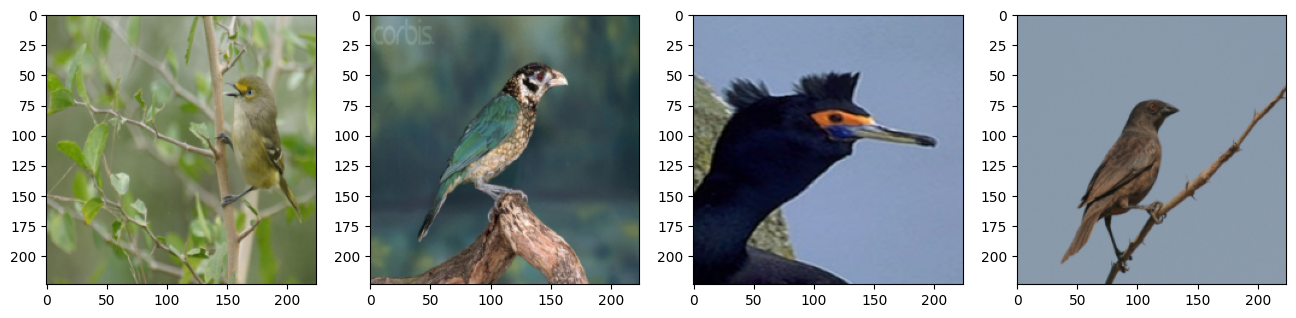

tensor([155,  17,  23,  25])


In [17]:
# Plot the training images and labels

cub_denormalize = transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], std=[1/0.229, 1/0.224, 1/0.225])
to_pil_image = transforms.functional.to_pil_image

images, labels = next(iter(cub_train_loader))

fig, ax = plt.subplots(1, 4, figsize=(16, 4))
ax[0].imshow(to_pil_image(cub_denormalize(images[0])))
ax[1].imshow(to_pil_image(cub_denormalize(images[1])))
ax[2].imshow(to_pil_image(cub_denormalize(images[2])))
ax[3].imshow(to_pil_image(cub_denormalize(images[3])))
plt.show()

print(labels[:4])

# 3. Define the Model Architecture

Here we define the model. Below is very simple model with CNN. You can customize your own model and note that you are not limited to use any methods. **But you are not allowed to use pretrained weight**

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False
    )

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, is_last=False):
        super(BasicBlock, self).__init__()
        self.is_last = is_last
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        preact = out
        out = F.relu(out)

        if self.is_last:
            return out, preact
        else:
            return out

class ResNet(nn.Module):
    def __init__(self, depth, num_filters, block_name="BasicBlock", num_classes=200):
        super(ResNet, self).__init__()
        n = (depth - 2) // 6
        block = BasicBlock

        self.inplanes = num_filters[0]
        self.conv1 = nn.Conv2d(3, num_filters[0], kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(num_filters[0])
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, num_filters[1], n)
        self.layer2 = self._make_layer(block, num_filters[2], n, stride=2)
        self.layer3 = self._make_layer(block, num_filters[3], n, stride=2)
        self.avgpool = nn.AvgPool2d(8)
        self.fc = nn.Linear(num_filters[3] * block.expansion, num_classes)
        self.stage_channels = num_filters

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(
                    self.inplanes,
                    planes * block.expansion,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(self.inplanes, planes, stride, downsample, is_last=(blocks == 1))
        )
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, is_last=(i == blocks - 1)))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)  # output size: 32x32 for CIFAR-like input
        x, _ = self.layer1(x)  # 32x32
        x, _ = self.layer2(x)  # 16x16
        x, _ = self.layer3(x)  # 8x8

        x = self.avgpool(x)
        avg = x.reshape(x.size(0), -1)
        out = self.fc(avg)
        return out

def resnet32x4(**kwargs):
    # depth=32, num_filters=[32, 64, 128, 256] for a 32x4 architecture
    return ResNet(32, [32, 64, 128, 256], "basicblock", **kwargs)

# Move model to device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = resnet32x4(num_classes=200)
model.to(device)


ResNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (b

# 4. Train the network

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# Define label-smoothing cross entropy loss
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Use AdamW optimizer for better convergence
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

EPOCHS = 30
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

for epoch in range(EPOCHS):
    model.train()
    n_iter = 0
    loss_total = 0
    acc_total = 0

    # Training loop
    for i, (inputs, targets) in enumerate(tqdm(cub_train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")):
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Reset gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Compute training accuracy
        pred = outputs.argmax(dim=-1)
        correct = pred.eq(targets).float().sum()
        acc = correct / targets.shape[0]
        loss_total += loss.item()
        acc_total += acc
        n_iter += 1

    train_loss = loss_total / n_iter
    train_acc = acc_total / n_iter

    print(f"Epoch: {epoch+1} - Train Loss: {train_loss:.3f} - Train Acc: {train_acc:.3f}")

    # Update the learning rate
    scheduler.step()

print('Finished Training')

# After training, you can run your separate validation code to check the validation accuracy.


Epoch 1/30:   0%|          | 0/94 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 784.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 87.06 MiB is free. Process 3683 has 14.66 GiB memory in use. Of the allocated memory 13.88 GiB is allocated by PyTorch, and 677.09 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

# 5. Evaluate the network on the validation data

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in cub_val_loader:
        images, labels = data
        outputs = model(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.cpu() == labels).sum().item()

print(f'Accuracy of the network on the 2897 validation images: {100 * correct / total:.2f} %')

Accuracy of the network on the 2897 validation images: 1.69 %


# 6. Test and Submit

You can modify your TestDataset, but you should be mindful to align it with the training dataset and its transformations.

In [ ]:
from torch.utils.data import Dataset
import numpy as np
from transformers import ViTFeatureExtractor
import torch

# Initialize a ViTFeatureExtractor with the same size and normalization
feature_extractor = ViTFeatureExtractor(
    size=224,  # Resize images to 224x224
    do_resize=True,
    resample=2, # BILINEAR
    do_center_crop=False,
    image_mean=[0.485, 0.456, 0.406],
    image_std=[0.229, 0.224, 0.225]
)

class TestDataset(Dataset):
    def __init__(self, img_file, feature_extractor=None):
        self.img = np.load(img_file)
        self.feature_extractor = feature_extractor

    def __len__(self):
        return len(self.img)

    def __getitem__(self, idx):
        # image is a numpy array of shape (H, W, C) in [0,255]
        image = self.img[idx]

        # The feature_extractor returns a dict with 'pixel_values' which are normalized tensors.
        # pass return_tensors="pt" to get a PyTorch tensor
        encoded = self.feature_extractor(images=image, return_tensors="pt")
        pixel_values = encoded["pixel_values"].squeeze(0)  # remove batch dimension

        return pixel_values

test_dataset = TestDataset(img_file="./CUB_test_images.npy", feature_extractor=feature_extractor)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Now you can run inference using your model as before
model.eval()
predictions = []
with torch.no_grad():
    for inputs in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())

# Save or submit predictions as needed


ImportError: cannot import name 'ViTFeatureExtractor' from 'transformers' (c:\Users\ChunghyunHan\anaconda3\Lib\site-packages\transformers\__init__.py)

## **Do not modify the cell below!!!!**


In [ ]:
def test(model, test_loader):
  model.eval()
  test_predictions = []

  with torch.inference_mode():
      for i, data in enumerate(tqdm(test_loader)):
          data = data.float().to(device)
          output = model(data)
          test_predictions.append(output.cpu())

  return torch.cat(test_predictions, dim=0)

In [ ]:
# Save test output npy file
predictions = test(model, test_loader)
np.save('./Test_results', predictions.numpy())